In [1]:
########################################
## import packages
########################################
%matplotlib inline
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,  Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


import gc
import seaborn as sns
from snownlp import SnowNLP
from collections import Counter
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score


import cPickle
import gensim
import math
from fuzzywuzzy import fuzz
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis


import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/scikit_learn-0.18.1-py2.7-linux-x86_64.egg/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
########################################
## set directories and parameters
########################################
BASE_DIR = 'data/'
EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300.bin'
TRAIN_DATA_FILE = BASE_DIR + 'cor_train.csv'
TEST_DATA_FILE = BASE_DIR + 'cor_test.csv'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.02

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

In [3]:
data_1 = np.loadtxt("data/data_1.csv", delimiter=",")
data_2 = np.loadtxt("data/data_2.csv", delimiter=",")
test_data_1 = np.loadtxt("data/test_data_1.csv", delimiter=",")
test_data_2 = np.loadtxt("data/test_data_2.csv", delimiter=",")
labels = np.loadtxt("data/labels.csv", delimiter=",")
embedding_matrix = np.load('data/embedding_matrix.npy')
nb_words = 120501

In [4]:
x_train = pd.read_pickle('data/x_train_norm.pkl')
x_test = pd.read_pickle('data/x_test_norm.pkl')

In [5]:
########################################
## sample train/validation data
########################################

np.random.seed(1234)
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))

data_3_train = np.vstack((x_train.values[idx_train],x_train.values[idx_train]))
data_3_val = np.vstack((x_train.values[idx_val],x_train.values[idx_val]))

labels_train = np.concatenate((labels[idx_train], labels[idx_train]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))


weight_val = np.ones(len(labels_val))

if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344
    class_weight = {0: 1.309028344, 1: 0.472001959}
    

In [13]:
num_lstm = 250
num_dense = 250
rate_drop_lstm = 0.6
rate_drop_dense = 0.5

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

In [14]:
########################################
## define the model structure
########################################
os.environ["CUDA_VISIBLE_DEVICES"]="5"

embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer =  Bidirectional(LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

z1 = Input(shape=(x_train.shape[1],), dtype='float32')
z1_dense = Dense(num_dense/2, activation=act)(z1)

merged = concatenate([x1, y1, z1_dense])
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [15]:
########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input, z1], \
        outputs=preds)
# model.load_weights(bst_model_path)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
#model.summary()
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_loss',save_best_only=True, save_weights_only=True)
# model.load_weights(bst_model_path)
hist = model.fit([data_1_train, data_2_train, data_3_train], labels_train, \
        validation_data=([data_1_val, data_2_val, data_3_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])


lstm_250_250_0.60_0.50
Train on 792408 samples, validate on 16172 samples
Epoch 1/200
792408/792408 [==============================] - 245s - loss: 0.2603 - acc: 0.8162 - val_loss: 0.2132 - val_acc: 0.8209
Epoch 2/200
792408/792408 [==============================] - 243s - loss: 0.2096 - acc: 0.8444 - val_loss: 0.2042 - val_acc: 0.8382
Epoch 3/200
792408/792408 [==============================] - 242s - loss: 0.2014 - acc: 0.8506 - val_loss: 0.1931 - val_acc: 0.8541
Epoch 4/200
792408/792408 [==============================] - 242s - loss: 0.1954 - acc: 0.8554 - val_loss: 0.1897 - val_acc: 0.8691
Epoch 5/200
792408/792408 [==============================] - 243s - loss: 0.1908 - acc: 0.8596 - val_loss: 0.1856 - val_acc: 0.8655
Epoch 6/200
792408/792408 [==============================] - 244s - loss: 0.1874 - acc: 0.8622 - val_loss: 0.1837 - val_acc: 0.8632
Epoch 7/200
792408/792408 [==============================] - 244s - loss: 0.1844 - acc: 0.8644 - val_loss: 0.1811 - val_acc: 0.8727
Ep

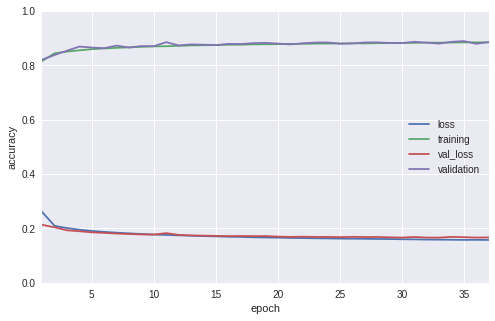

In [16]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in hist.epoch ],
                    'training': hist.history['acc'],
                    'validation': hist.history['val_acc'],
                    'loss': hist.history['loss'],
                   'val_loss': hist.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [17]:
bst_val_score = min(hist.history['val_loss'])

########################################
## make the submission
########################################
model.load_weights(bst_model_path)

preds = model.predict([test_data_1, test_data_2, x_test.values], batch_size=5000, verbose=1)
preds += model.predict([test_data_2, test_data_1, x_test.values], batch_size=5000, verbose=1)
preds /= 2

test_ids = np.arange(len(preds))
submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)


2345796/2345796 [==============================] - 235s   


In [20]:
print '%.4f_'%(bst_val_score)+STAMP

0.1663_lstm_250_250_0.60_0.50


In [21]:
print x_train.columns


Index([u'word_match', u'tfidf_word_match', u'sentiment', u'diff_len',
       u'diff_len_char', u'diff_len_word', u'q1_freq', u'q2_freq',
       u'cosine_distance', u'cityblock_distance', u'jaccard_distance',
       u'canberra_distance', u'euclidean_distance', u'minkowski_distance',
       u'braycurtis_distance', u'skew_q1vec', u'skew_q2vec', u'kur_q1vec',
       u'kur_q2vec', u'fuzz_qratio', u'fuzz_WRatio', u'fuzz_partial_ratio',
       u'fuzz_partial_token_set_ratio', u'fuzz_partial_token_sort_ratio',
       u'fuzz_token_set_ratio', u'fuzz_token_sort_ratio', u'q1_q2_intersect',
       u'q1_q2_wm_ratio'],
      dtype='object')
